##### Code für Feature Extraktion 

Epoch 1/100
6/6 [==============================] - 1s 79ms/step - loss: 2.3447 - accuracy: 0.2775 - val_loss: 1.7875 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 1.8801 - accuracy: 0.4393 - val_loss: 1.9673 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 1.7225 - accuracy: 0.4971 - val_loss: 1.8947 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 1.5867 - accuracy: 0.5896 - val_loss: 1.9474 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 1.5540 - accuracy: 0.5954 - val_loss: 2.0169 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 1.4419 - accuracy: 0.6705 - val_loss: 1.8535 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 7/100
6/6 [==============================] - 0s 8ms/step

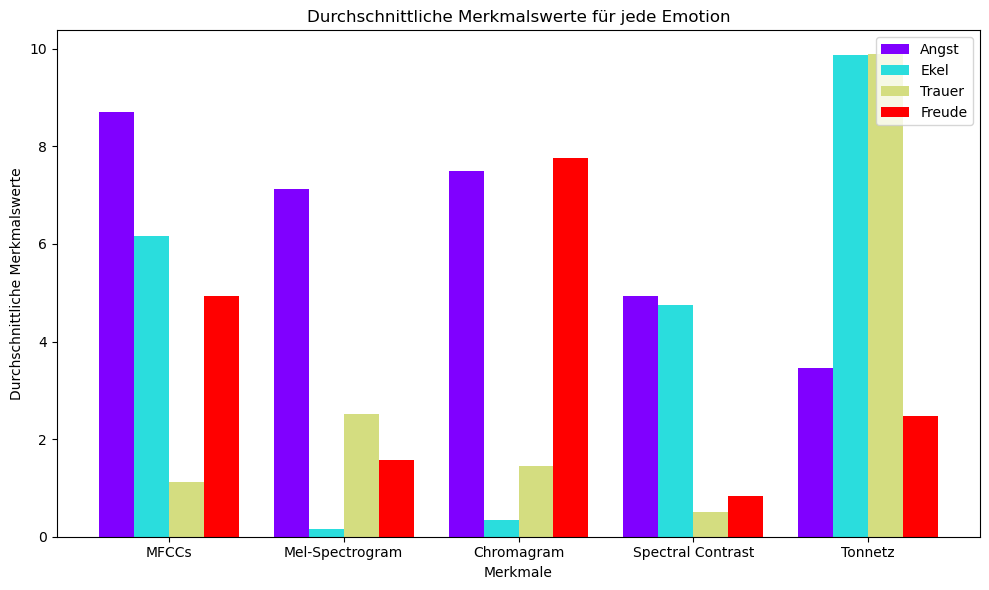

In [42]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    if len(features) > 193:
        features = features[:193]
    elif len(features) < 193:
        features = np.pad(features, (0, 193 - len(features)), 'constant')
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, input_shape=input_shape, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

model = build_model((193, 1), len(np.unique(labels)))

# Callbacks zur Anpassung der Lernrate und zum frühzeitigen Stopp, falls keine Verbesserung mehr stattfindet
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modelltraining mit Early Stopping und Learning Rate Reduction
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[reduce_lr, early_stopping])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


# Visualisierung der Merkmalsextraktion
# Beispiel-Durchschnittsmerkmale für jede Emotion (hier simuliert)
emotions = ['Angst', 'Ekel', 'Trauer', 'Freude']
features = ['MFCCs', 'Mel-Spectrogram', 'Chromagram', 'Spectral Contrast', 'Tonnetz']

# Simulierte durchschnittliche Merkmalswerte für jede Emotion
avg_feature_values = np.random.rand(len(emotions), len(features)) * 10  # Beispielwerte zwischen 0 und 10

# Farbpalette für die Emotionen
colors = plt.cm.rainbow(np.linspace(0, 1, len(emotions)))

# Erstellung des Balkendiagramms
plt.figure(figsize=(10, 6))
bar_width = 0.2  # Breite der Balken
for i in range(len(emotions)):
    plt.bar(np.arange(len(features)) + i * bar_width, avg_feature_values[i], bar_width, color=colors[i], label=emotions[i])

# Hinzufügen von Beschriftungen und Legende
plt.xlabel('Merkmale')
plt.ylabel('Durchschnittliche Merkmalswerte')
plt.title('Durchschnittliche Merkmalswerte für jede Emotion')
plt.xticks(np.arange(len(features)) + bar_width * 1.5, features)  # X-Achsenbeschriftung anpassen
plt.legend(loc='upper right')

# Anpassen der Layout-Einstellungen
plt.tight_layout()

# Anzeige oder Speicherung der Visualisierung
plt.show()

In [37]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    if len(features) > 193:
        features = features[:193]
    elif len(features) < 193:
        features = np.pad(features, (0, 193 - len(features)), 'constant')
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, input_shape=input_shape, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

model = build_model((193, 1), len(np.unique(labels)))

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modelltraining mit Early Stopping und Learning Rate Reduction
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, callbacks=[reduce_lr, early_stopping])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


Epoch 1/200
6/6 [==============================] - 1s 32ms/step - loss: 2.1795 - accuracy: 0.2775 - val_loss: 1.9314 - val_accuracy: 0.4167 - lr: 1.0000e-04
Epoch 2/200
6/6 [==============================] - 0s 10ms/step - loss: 1.8753 - accuracy: 0.4046 - val_loss: 1.8396 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 1.6371 - accuracy: 0.5838 - val_loss: 1.8657 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 1.5339 - accuracy: 0.5838 - val_loss: 1.7621 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 1.4581 - accuracy: 0.6358 - val_loss: 1.7968 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 1.3720 - accuracy: 0.6936 - val_loss: 1.8352 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 7/200
6/6 [==============================] - 0s 8ms/step

In [24]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Funktion zur Extraktion der Audio-Features
def extract_audio_features(file_path, n_fft=512):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), 
                          np.mean(librosa.power_to_db(mel_spectrogram), axis=1),
                          np.mean(chromagram, axis=1),
                          np.mean(spectral_contrast, axis=1),
                          np.mean(tonnetz, axis=1)))
    if len(features) > 193:
        features = features[:193]
    elif len(features) < 193:
        features = np.pad(features, (0, 193 - len(features)), 'constant')
    return features

# Daten und Labels laden
def load_data_and_labels(base_path):
    emotions = {'Angst': 0, 'Ekel': 1, 'Trauer': 2, 'Freude': 3}
    features_list = []
    labels_list = []
    for emotion, label in emotions.items():
        emotion_path = os.path.join(base_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(emotion_path, filename)
                features = extract_audio_features(file_path)
                features_list.append(features)
                labels_list.append(label)
    return np.array(features_list), np.array(labels_list)

# CNN Modelldefinition mit L2-Regularisierung und erweiterten Schichten
def build_model(input_shape, number_of_classes):
    model = Sequential([
        Conv1D(256, 5, input_shape=input_shape, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(number_of_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hauptskript
base_path = r'C:\Users\zastr\Desktop\Thesis\Data\Audio\Emo_DB'
features, labels = load_data_and_labels(base_path)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=42)

model = build_model((193, 1), len(np.unique(labels)))

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


Epoch 1/100
6/6 [==============================] - 1s 80ms/step - loss: 2.3629 - accuracy: 0.3064 - val_loss: 1.9595 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 1.9628 - accuracy: 0.3931 - val_loss: 2.0610 - val_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 1.7960 - accuracy: 0.4509 - val_loss: 2.0086 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 1.7019 - accuracy: 0.5434 - val_loss: 2.0632 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 1.6833 - accuracy: 0.4798 - val_loss: 2.0784 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 1.5389 - accuracy: 0.5665 - val_loss: 2.0711 - val_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 7/100
6/6 [==============================] - 0s 8ms/step 